State space:    - 4 continuous variables:
                    - Cart Position; Limits: [-4.8, 4.8]
                    - Cart Velocity; Limits: [-Inf, Inf]
                    - Pole Angle; Limits: [-24 deg, 24 deg]
                    - Pole Angular Velocity; Limits: [-Inf, Inf]
            
Action space:   - 2 discrete actions:
                    - Push cart to the left
                    - Push cart to the right
                    
Environment dynamics:   - Start: all variables (Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity) 
                        start with a random value between -0.05 and +0.05
                        - End: 
                            1. Pole is no longer balanced (angle greater than +-12 degrees)
                            2. Cart reaches the edge of the envrionment (Cart Position greater than +-2.4)
                            3. Maximum episode length is met (in this case 500 time steps)
                            
Reward structure:   - Option 1: +1 for each time step the pole is balanced
                    - Option 2: 0 for all time steps, -1 when the pole falls (and the episode terminates, see above)

In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [10]:
"""
Simple Simulation of the CartPole environment; 
code structure taken from gym documentation. The loop chooses a random action at each time step.
The action is then executed and the environment is rendered. Rendering is delayed by 0.1 seconds after each step,
as otherwise the simulation terminates after <1 second and cannot actually be observed by humans.
"""
env = gym.make("CartPole-v1", render_mode = "human") #Create the environment

observation, info = env.reset() #obligatory reset

episode_over = False
while not episode_over:
    action = env.action_space.sample() #sample random action (either 0 or 1, left or right)
    observation, reward, terminated, truncated, info = env.step(action) #action is performed
    
    print(observation)
    
    env.render() #environment is rendered
    time.sleep(0.1) #delay
    
    #if either a termination condition is met or the maximum episode length is reached, the loop needs to end
    episode_over = terminated or truncated 

env.close() #close the environment

[ 0.03746238 -0.21115932  0.04881892  0.26271296]
[ 0.03323919 -0.4069429   0.05407317  0.5703855 ]
[ 0.02510033 -0.2126193   0.06548089  0.2952159 ]
[ 0.02084794 -0.01848901  0.0713852   0.02388216]
[ 0.02047816  0.17554046  0.07186285 -0.24545138]
[ 0.02398897 -0.02053038  0.06695382  0.06900529]
[ 0.02357837 -0.21654518  0.06833392  0.3820384 ]
[ 0.01924746 -0.4125675   0.0759747   0.6954602 ]
[ 0.01099611 -0.60865635  0.08988389  1.0110601 ]
[-1.1770148e-03 -8.0485529e-01  1.1010510e-01  1.3305607e+00]
[-0.01727412 -1.0011803   0.1367163   1.6555705 ]
[-0.03729773 -1.1976072   0.16982773  1.9875311 ]
[-0.06124987 -1.0046263   0.20957835  1.7519137 ]


: 

In [5]:
def simple_policy(observation, borders=False, even=False, lowAngSpeed=False, lowCartSpeed=False):
    """
    Simple policy which uses the given observation to choose whether to push the cart left or right.
    """
    if borders:
        if observation[0] < -2.3:
            return 1
        elif observation[0] > 2.3:
            return 0
    
    if lowAngSpeed:
        if observation[3] < -1.5 or observation[3] > 1.5:
            return 0 if observation[3] < 0 else 1
        
    if lowCartSpeed:
        if observation[1] < -1.5 or observation[1] > 1.5:
            return 0 if observation[1] < 0 else 1
    
    if even: 
        if -0.05 < observation[2] < 0.05: #equates to ~3 degrees
            return random.choice([0, 1])
    
    return 0 if observation[2] < 0 else 1 #if the pole leans left, push cart left, otherwise push cart right

In [6]:
def run_env(borders=False, even=False, lowAngSpeed=False, lowCartSpeed=False, render=False):
    """
    Execution of the CartPole environment using own policies; rest as above.
    """
    env = gym.make("CartPole-v1") #Create the environment
    
    observation, info = env.reset() #obligatory reset
    
    reward_cum = 0
    episode_over = False
    while not episode_over:
        action = simple_policy(observation, borders=borders, even=even, lowAngSpeed=lowAngSpeed, lowCartSpeed=lowCartSpeed)
        observation, reward, terminated, truncated, info = env.step(action) #action is performed
        
        #print(observation) if observation[1] < -1.5 or observation[1] > 1.5 else None
        reward_cum += reward
        
        if render: 
            env.render() #environment is rendered
        
        #if either a termination condition is met or the maximum episode length is reached, the loop needs to end
        episode_over = terminated or truncated 
    
    env.close() #close the environment
    return reward_cum


In [7]:
def run_episodes(n=100):
    
    mean_rewards = []
    
    #simplest form
    mean_rewards.append(np.mean([run_env(borders=False, even=False, lowAngSpeed=False, lowCartSpeed=False) for _ in range(n)]))
    
    #form that generally tries to keep pole upright
    mean_rewards.append(np.mean([run_env(borders=False, even=True, lowAngSpeed=False, lowCartSpeed=False) for _ in range(n)]))
    
    #form that also tries to stay in bounds
    mean_rewards.append(np.mean([run_env(borders=True, even=True, lowAngSpeed=False, lowCartSpeed=False) for _ in range(n)]))
    
    #form that keeps angular speed within limits
    mean_rewards.append(np.mean([run_env(borders=True, even=True, lowAngSpeed=True, lowCartSpeed=False) for _ in range(n)]))
    
    #form that keeps angular speed within limits, but is not concerned with borders
    mean_rewards.append(np.mean([run_env(borders=False, even=True, lowAngSpeed=True, lowCartSpeed=False) for _ in range(n)]))
    
    #form that also keeps cart speed within limits
    mean_rewards.append(np.mean([run_env(borders=True, even=True, lowAngSpeed=True, lowCartSpeed=True) for _ in range(n)]))
    
    return mean_rewards


In [8]:
num_policies = 6
num_runs = 10

mean_reward_array = np.ndarray((num_runs, num_policies))
for i in range(num_runs):
    mean_rewards = run_episodes(n=200)
    mean_reward_array[i] = mean_rewards

print(mean_reward_array)

[[ 42.58   48.02   50.595 345.345 341.65  250.625]
 [ 42.25   48.56   46.7   321.845 344.065 249.35 ]
 [ 41.94   50.545  49.605 346.02  359.83  247.465]
 [ 42.02   50.25   52.    330.635 333.475 254.175]
 [ 41.17   48.995  50.87  328.25  347.325 250.985]
 [ 42.55   49.635  49.53  351.45  329.405 241.17 ]
 [ 43.5    49.55   49.585 330.02  328.625 252.025]
 [ 42.67   47.67   48.615 332.785 333.925 235.45 ]
 [ 42.515  55.245  46.5   340.425 330.205 241.97 ]
 [ 42.77   49.505  48.675 314.79  326.225 255.26 ]]


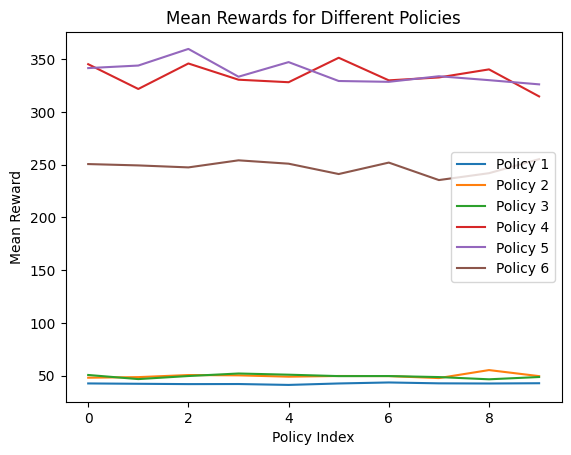

In [9]:
for i in range(num_policies):
    plt.plot(np.transpose(mean_reward_array)[i], label=f'Policy {i+1}')

plt.xlabel('Policy Index')
plt.ylabel('Mean Reward')
plt.title('Mean Rewards for Different Policies')
plt.legend()
plt.show()

It can be clearly seen that the simplest approach, i.e. moving in the opposite direction of the pole's lean is the worst policy.
When watching the actual simulation, it can be seen that this very quickly results in overcorrection on the agents part, 
with the pole oscillating faster and faster, leading to a fall.
This is slightly improved by just choosing a random direction when the pole is (nearly) upright. Choosing a random direction 
is an approach to simulate "doing nothing" in a sense, as the pole is already balanced and no action is required.
A significant improvement is achieved when correcting for the angular velocity of the pole, as this directly combats the oscillation
and therefore the tendency to overcorrect.
Interestingly, it can be seen that ensuring that the cart stays within its positional bounds does not significantly improve the 
performance of the agent. This is likely to the fact that the cart needs a long time to move to the outer edges, meaning that 
the case in which the cart reaches the edge is rare and therefore does not significantly impact the overall performance.
Lastly, taking the cart velocity into consideration does decrease the agents performance. This is probably because it tends to 
unnecessarily change the direction of the cart, which leads to additional angular velocity for the pole, rather than helping to 
keep it low and the pole upright.